In [1]:
import numpy as np
import random
import json
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import glob

from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
torch.backends.cudnn.deterministic=True 

In [80]:
meta = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/meta.json', 'r'))
tokens = meta['tokens']
num_token = len(tokens)
num_user = meta['num_user']
print('In dataset, there are {} number of tokens (words) and these tweets are from {} users'.format(num_token, num_user))

In dataset, there are 13369 number of tokens (words) and these tweets are from 8 users


In [81]:
train_data = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/train.json', 'r'))
valid_data = json.load(open('/content/drive/MyDrive/TUM/assignments i2dl/assignment2/valid.json', 'r'))
s_idx = 0
print('{} tweets in train dataset, {} tweets in valid dataset.'.format(len(train_data), len(valid_data)))
print('Each json file is a list of dictionary, and each dictionary has information of tweets')
print('[TWEET INFO]: user id, sentence, processed token id.')
print()

print('Sample train data: ', train_data[s_idx])
print()
print('Note that: tokens.index(word) = token_id')
print()
print('Example:')
print(train_data[0]['token_id'])
print([tokens.index(w) for w in train_data[s_idx]['sentence'].split()])

6400 tweets in train dataset, 356 tweets in valid dataset.
Each json file is a list of dictionary, and each dictionary has information of tweets
[TWEET INFO]: user id, sentence, processed token id.

Sample train data:  {'user_id': 0, 'sentence': 'i recently met lakeisha crum the first in her family to go to college loved her story', 'token_id': [5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]}

Note that: tokens.index(word) = token_id

Example:
[5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]
[5721, 9659, 7459, 6629, 2686, 11853, 4447, 5870, 5460, 4236, 12017, 4981, 12017, 2197, 7047, 5460, 11310]


In [82]:
class tweetDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        sample['token_id'] = torch.Tensor(sample['token_id'])
        return sample

In [83]:
train_dataset = tweetDataset(train_data)
valid_dataset = tweetDataset(valid_data)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

In [84]:
sample = next(iter(train_dataloader))

print('Sample from train dataloader: ')
print('USER ID: ', sample['user_id'])
print('TOKEN ID: ', sample['token_id'])
print('TOKEN ID shape should be BATCH by LENGTH: ', sample['token_id'].shape)

Sample from train dataloader: 
USER ID:  tensor([0])
TOKEN ID:  tensor([[ 7553.,  1316.,  4186.,  7699.,  3820.,  4700., 11853., 11465.,  5534.,
         11853.,  3572.,  5870.,  8326.,  5634., 11842.,  5677., 12579.,  5870.,
           481.,  3869., 13269.]])
TOKEN ID shape should be BATCH by LENGTH:  torch.Size([1, 21])


In [86]:
class Model(nn.Module):
    def __init__(self, num_token, num_user, embed_dim, rnn_dim, num_layers):
        super(Model, self).__init__()
        self.num_token = num_token
        self.num_user = num_user
        self.embed_dim = embed_dim
        self.rnn_dim = rnn_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(num_token, embed_dim)

        self.rnn1 = nn.GRU(embed_dim, rnn_dim, num_layers=num_layers, batch_first=True)
        self.rnn2 = nn.GRU(rnn_dim, rnn_dim, num_layers=num_layers, batch_first=True)

        self.dropout = nn.Dropout(p=0.2)
        self.attn = nn.MultiheadAttention(rnn_dim, 1, dropout=0.2)

        self.out_linear = nn.Linear(rnn_dim, num_user)

    def forward(self, token_id):
        embed = self.embedding(token_id)
        embed = self.dropout(embed)

        out1, _ = self.rnn1(embed) # for encoder, q, k, v are the same
        temp_out1 = self.dropout(out1)
        temp_out1, _ = self.attn(temp_out1, temp_out1, temp_out1)

        #print(temp_out1.shape)

        out2, _ = self.rnn2(out1) # for encoder, q, k, v are the same
        temp_out2 = self.dropout(out2)
        temp_out2, _ = self.attn(temp_out2, temp_out2, temp_out2)

        #print(temp_out2.shape)

        out = torch.cat([temp_out1, temp_out2], dim=1)

        #print(out.shape)

        return self.out_linear(out[:, -1])

In [87]:
device = 'cuda'
#device = 'cpu'

model = Model(num_token, num_user, embed_dim=512, rnn_dim=947, num_layers=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-7)

In [88]:
num_param = sum(p.numel() for p in model.parameters())
print('Number of parameters: {}'.format(num_param))
print('[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).')
pred = model(sample['token_id'].long().to(device))
print('Prediction shape would be BATCH X NUM_USER(OUTPUT) : ', pred.shape)

Number of parameters: 19980773
[NOTE] Number of parameters SHOULD NOT exceed 20,000,000 (20 million).
Prediction shape would be BATCH X NUM_USER(OUTPUT) :  torch.Size([1, 8])


In [89]:
criteria = nn.CrossEntropyLoss()
avg_loss = 0.0
best_valid_accu = 0.0
best_epoch = -1
best_model = None
num_epoch = 300
x,y = [],[]

for epoch in tqdm(range(num_epoch)):
    # start training
    for sample in train_dataloader:
        model.train()
        optimizer.zero_grad()

        pred = model(sample['token_id'].long().to(device))

        loss = criteria(pred, sample['user_id'].long().to(device))

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_dataloader)

    # start validation
    correct_cnt = 0.0
    data_cnt = 0.0
    for sample in valid_dataloader:
        model.eval()

        with torch.no_grad():
            pred = model(sample['token_id'].long().to(device))

        pred_user_id = torch.argmax(pred, dim=-1)

        accu = pred_user_id.detach().cpu() == sample['user_id']

        correct_cnt += torch.sum(accu)
        data_cnt += sample['token_id'].shape[0]

    # calculate best valid accuracy, and save the best model. 
    curr_valid_accu = (correct_cnt / data_cnt).item()
    print('[EPOCH {}] VALID ACCURACY: {}'.format(epoch, curr_valid_accu))
    x.append(epoch)
    y.append(curr_valid_accu)

    best_valid_accu = max(best_valid_accu, curr_valid_accu)
    if best_valid_accu == curr_valid_accu:
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'GRU_best_baseline.pth')
        print('[EPOCH {}] BEST VALID ACCURACY UPDATED: {}'.format(epoch, best_valid_accu))

print('FINISHED TRAINING : BEST MODEL AT EPOCH {} WITH ACCURACY {}'.format(best_epoch, best_valid_accu))

  0%|          | 0/300 [00:00<?, ?it/s]

[EPOCH 0] VALID ACCURACY: 0.449438214302063
[EPOCH 0] BEST VALID ACCURACY UPDATED: 0.449438214302063
[EPOCH 1] VALID ACCURACY: 0.5533707737922668
[EPOCH 1] BEST VALID ACCURACY UPDATED: 0.5533707737922668
[EPOCH 2] VALID ACCURACY: 0.5955055952072144
[EPOCH 2] BEST VALID ACCURACY UPDATED: 0.5955055952072144
[EPOCH 3] VALID ACCURACY: 0.6235954761505127
[EPOCH 3] BEST VALID ACCURACY UPDATED: 0.6235954761505127
[EPOCH 4] VALID ACCURACY: 0.617977499961853
[EPOCH 5] VALID ACCURACY: 0.6264045238494873
[EPOCH 5] BEST VALID ACCURACY UPDATED: 0.6264045238494873
[EPOCH 6] VALID ACCURACY: 0.6432584524154663
[EPOCH 6] BEST VALID ACCURACY UPDATED: 0.6432584524154663
[EPOCH 7] VALID ACCURACY: 0.6938202381134033
[EPOCH 7] BEST VALID ACCURACY UPDATED: 0.6938202381134033
[EPOCH 8] VALID ACCURACY: 0.648876428604126
[EPOCH 9] VALID ACCURACY: 0.6713483333587646
[EPOCH 10] VALID ACCURACY: 0.665730357170105
[EPOCH 11] VALID ACCURACY: 0.6544944047927856
[EPOCH 12] VALID ACCURACY: 0.6769663095474243
[EPOCH 13] 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

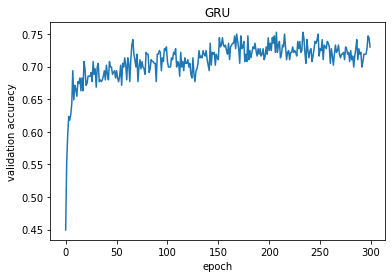

In [90]:
print(x)
print(y)

import matplotlib.pyplot as plt
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('epoch')
# naming the y axis
plt.ylabel('validation accuracy')
 
# giving a title to my graph
plt.title('GRU')
 
# function to show the plot
plt.show()